#Detection of Potential Labour Trafficking from Online Job Advertisements

####Dataset: https://docs.google.com/spreadsheets/d/1nmVxw7iXkJccaWHDy8DmxPO3BFkoWXQj/edit?usp=sharing&ouid=114382185693817861245&rtpof=true&sd=true

##1. Web Scraping (Extract > Transform > Load) - Data Collection

In [2]:
#Mount data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Import relevant packages

#Web Scrapping
import requests #allow to send HTTP requests 
from bs4 import BeautifulSoup #allow parsing HTML and XML documents to extract data from HTML

#Data Manipulation
import pandas, xgboost
import pandas as pd #for data manipulation
import numpy as np #arrays
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
from collections import Counter

#Text/Data Pre-Processing
import string
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install contractions
import contractions
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import spacy
from sklearn.feature_extraction.text import CountVectorizer

#Model building
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Performance evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 321 kB 5.1 MB/s 
     |████████████████████████████████| 284 kB 62.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85444 sha256=96fbb2f349f52d06718c3afb9242eebee5f58a2090ea78f582151c7aa8287295
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [4]:
#To check whether the website is extractable

#Labourer
def extract(page):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15'}
    url = f'https://uk.indeed.com/jobs?q=labourer&l=United+Kingdom&start={page}' #website link
    r = requests.get(url, headers)
    return r.status_code

print(extract(0)) #first page


200


In [5]:
#To extract job title

def extract(page):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15'}
    url = f'https://uk.indeed.com/jobs?q=labourer&l=United+Kingdom&start={page}' #website link
    r = requests.get(url, headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    return soup
  
def transform(soup):
    divs = soup.find_all('div', class_ = 'slider_container')
    for i in divs:
        title = i.find('h2').text.strip() #find the title but remove wide spaces
        title2 = title.replace('new','') #remove the word 'new'
        print(title2)
    return

data = extract(0)
transform(data)

Labourer
Warehouse Operatives
Labourer
Labourer
Labourer
CSCS Labourer
Labourer
Labourer- Ecclesden Park
Yardsperson /Labourer
CSCS Labourer
Farm Worker
Labourer
Warehouse Workers
Warehouse Operative
Labourer (Day to Day)


In [6]:
#To extract job title, salary and summary

def extract(page):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15'}
    url = f'https://uk.indeed.com/jobs?q=labourer&l=United+Kingdom&start={page}' #website link
    r = requests.get(url, headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    return soup
  
def transform(soup):
    divs = soup.find_all('div', class_ = 'slider_container')
    for i in divs:
        title = i.find('h2').text.strip() #find the title but remove wide spaces
        title2 = title.replace('new','') #remove the word 'new'
        try:
          salary = i.find('div', class_ = 'salary-snippet').text.strip()
        except:
          salary = ''
        summary = i.find('div', class_ = 'job-snippet').text.strip()

        job = {
             'title': title2,
             'salary': salary,
             'summary': summary
        }

        joblist.append(job)
    return

joblist = []
data = extract(0)
transform(data)
print(joblist)



[{'title': 'Labourer', 'salary': '£22,183 a year', 'summary': 'To be responsible for providing general support and assistance to skilled and specialist operatives within Road Works.'}, {'title': 'Warehouse Operatives', 'salary': '£34,000 a year', 'summary': 'Do you want to earn a basic salary of £24,000 plus one days overtime a week is £34,000 per annum.\nCan you work a rotating shift pattern of 4 days on 4 days off,…'}, {'title': 'Labourer', 'salary': '', 'summary': 'Reporting to the Site Manager, to ensure that all labouring tasks are completed to the highest standard and within the required timescales.'}, {'title': 'Labourer', 'salary': '', 'summary': 'Working closely with the Senior Labourer and the Facilities Administrators, you will ensure that the property/premises are maintained to a high standard and to…'}, {'title': 'Labourer', 'salary': '£14 an hour', 'summary': 'You will be assisting Electricians and Electrical Improvers on site, you will need your CSCS card.'}, {'title': '

In [7]:
#Labourer
#To extract job title, salary and summary

def extract(page):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15'}
    url = f'https://uk.indeed.com/jobs?q=labourer&l=United+Kingdom&start={page}' #website link
    r = requests.get(url, headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    return soup
  
def transform(soup):
    divs = soup.find_all('div', class_ = 'slider_container')
    for i in divs:
        title = i.find('h2').text.strip() #find the title but remove wide spaces
        title2 = title.replace('new','') #remove the word 'new'
        try:
          salary = i.find('div', class_ = 'salary-snippet').text.strip()
        except:
          salary = ''
        summary = i.find('div', class_ = 'job-snippet').text.strip()

        job = {
             'title': title2,
             'salary': salary,
             'summary': summary
        }

        joblist.append(job)
    return

joblist = []
data = extract(0)
transform(data)

for x in range(0,900,10):
  print(f'Getting page, {x}')
  data = extract(0)
  transform(data)

print(joblist)

##Domestic Cleaner/Worker
#To extract job title, salary and summary

def extract2(page):
    headers2 = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15'}
    url2 = f'https://uk.indeed.com/jobs?q=domestic+cleaner&l=United+Kingdom&start={page}' #website link
    r2 = requests.get(url2, headers2)
    soup2 = BeautifulSoup(r2.content, 'html.parser')
    return soup2
  
def transform2(soup):
    divs2 = soup.find_all('div', class_ = 'slider_container')
    for i in divs2:
        title1_2 = i.find('h2').text.strip() #find the title but remove wide spaces
        title2_2 = title1_2.replace('new','') #remove the word 'new'
        try:
          salary2 = i.find('div', class_ = 'salary-snippet').text.strip()
        except:
          salary2 = ''
        summary2 = i.find('div', class_ = 'job-snippet').text.strip()

        job2 = {
             'title': title2_2,
             'salary': salary2,
             'summary': summary2
        }

        joblist2.append(job2)
    return


joblist2 = []
data2 = extract2(0)
transform2(data2)
print(joblist2)

for x in range(0,900,10):
  print(f'Getting page, {x}')
  data2 = extract2(0)
  transform2(data2)

print(joblist2)


Getting page, 0
Getting page, 10
Getting page, 20
Getting page, 30
Getting page, 40
Getting page, 50
Getting page, 60
Getting page, 70
Getting page, 80
Getting page, 90
Getting page, 100
Getting page, 110
Getting page, 120
Getting page, 130
Getting page, 140
Getting page, 150
Getting page, 160
Getting page, 170
Getting page, 180
Getting page, 190
Getting page, 200
Getting page, 210
Getting page, 220
Getting page, 230
Getting page, 240
Getting page, 250
Getting page, 260
Getting page, 270
Getting page, 280
Getting page, 290
Getting page, 300
Getting page, 310
Getting page, 320
Getting page, 330
Getting page, 340
Getting page, 350
Getting page, 360
Getting page, 370
Getting page, 380
Getting page, 390
Getting page, 400
Getting page, 410
Getting page, 420
Getting page, 430
Getting page, 440
Getting page, 450
Getting page, 460
Getting page, 470
Getting page, 480
Getting page, 490
Getting page, 500
Getting page, 510
Getting page, 520
Getting page, 530
Getting page, 540
Getting page, 550
Get

In [8]:
#Combine both text data of labourers and domestic workers

joblist.extend(joblist2)

df = pd.DataFrame(joblist)

display(df)

df.to_excel('jobs.xlsx')

,title,salary,summary
0,Labourer,"£22,183 a year",To be responsible for providing general suppor...
1,Warehouse Operatives,"£34,000 a year","Do you want to earn a basic salary of £24,000 ..."
2,Labourer,,"Reporting to the Site Manager, to ensure that ..."
3,Labourer,,Working closely with the Senior Labourer and t...
4,Labourer,£14 an hour,You will be assisting Electricians and Electri...
...,...,...,...
2230,Domestic Cleaner,£8.91 an hour,Carry out all cleaning duties as directed by t...
2231,Domestic Cleaner,£12 - £16 an hour,We are looking for experienced domestic cleane...
2232,House Cleaner,£10 - £12 an hour,We are looking for experienced domestic cleane...
2233,Domestic Cleaner,£10.20 an hour,£10.20* per hour (including positive attendanc...


##2. Labelling the Text Features into Potential/Not Potential Labour Trafficking Based On Expertise & Related Works' Requirements

In [9]:
#Outcome of labelled text
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/CP2/jobs_final.xlsx')

In [10]:
#To check 5 rows of data
data.iloc[300:305,]

,title,salary2,salary,summary,target,justification
300,Shop Assistant / General Worker,13.57,13.570000,Serving customers and keeping areas clean and ...,Potential,Working experience or relevant skills is not r...
301,Labourer,14.00,14.000000,You will be assisting Electricians and Electri...,Not Potential,NaN
302,Domestic Cleaner,42644.00,17.084936,We are looking for experienced domestic cleane...,Potential,"Temporary, part-time or no contract job"
303,Domestic Cleaner,14846.00,5.947917,Our aim is to deliver outstanding care and sup...,Potential,Salary offered is below the UK labour law; Min...
304,Labourer,23625.00,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential,"Expenses for tools, accommodation and transpor..."


In [11]:
#To include only relevant features (excluding justification)
data2 = data.drop(['justification','title','salary2'], axis=1)
data2.head()

,salary,summary,target
0,10.000000,Previous experience as a cleaner.\nDisposal of...,Not Potential
1,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential
2,10.000000,We cover you in our insurance.\nGet paid cash ...,Not Potential
3,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential
4,NaN,To carry out daily cleaning duties to required...,Not Potential


##3. Text Pre-Processing

In [12]:
#Shuffle data
train = shuffle(data2)

train = train.dropna() #remove any missing values
display(train.shape, train.head())


(2317, 3)

,salary,summary,target
2285,13.570000,Serving customers and keeping areas clean and ...,Potential
1254,5.947917,Our aim is to deliver outstanding care and sup...,Potential
1022,8.910000,Your main aim will be to carry out a range of ...,Not Potential
2122,12.019231,Some travel and overnighters will be part of t...,Potential
853,13.570000,Serving customers and keeping areas clean and ...,Potential


In [13]:
#1. Lowercase
train["clean_summary"] = train["summary"].apply(lambda x: x.lower())
display(train.head())



,salary,summary,target,clean_summary
2285,13.570000,Serving customers and keeping areas clean and ...,Potential,serving customers and keeping areas clean and ...
1254,5.947917,Our aim is to deliver outstanding care and sup...,Potential,our aim is to deliver outstanding care and sup...
1022,8.910000,Your main aim will be to carry out a range of ...,Not Potential,your main aim will be to carry out a range of ...
2122,12.019231,Some travel and overnighters will be part of t...,Potential,some travel and overnighters will be part of t...
853,13.570000,Serving customers and keeping areas clean and ...,Potential,serving customers and keeping areas clean and ...


In [14]:
#2. Expand the contractions
train["clean_summary"] = train["clean_summary"].apply(lambda x: contractions.fix(x))
display(train.head())

,salary,summary,target,clean_summary
2285,13.570000,Serving customers and keeping areas clean and ...,Potential,serving customers and keeping areas clean and ...
1254,5.947917,Our aim is to deliver outstanding care and sup...,Potential,our aim is to deliver outstanding care and sup...
1022,8.910000,Your main aim will be to carry out a range of ...,Not Potential,your main aim will be to carry out a range of ...
2122,12.019231,Some travel and overnighters will be part of t...,Potential,some travel and overnighters will be part of t...
853,13.570000,Serving customers and keeping areas clean and ...,Potential,serving customers and keeping areas clean and ...


In [15]:
#3. Removal of unnecessary characters or punctuations

#3.1 Remove URL in case there is any:

def remove_URL(summary):
    
    return re.sub(r"https?://\S+|www\.\S+", "", summary)

train["clean_summary"] = train["clean_summary"].apply(lambda x: remove_URL(x))

#3.2 Remove HTML tags:

def remove_html(summary):
  
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", summary)

train["clean_summary"] = train["clean_summary"].apply(lambda x: remove_html(x))

#3.3 Remove non-ASCI:

def remove_non_ascii(summary):
    
    return re.sub(r'[^\x00-\x7f]',r'', summary)

train["clean_summary"] = train["clean_summary"].apply(lambda x: remove_non_ascii(x))

#3.4 Remove punctuations:

def remove_punctuations(summary):
  
    return summary.translate(str.maketrans('', '', string.punctuation))

train["clean_summary"] = train["clean_summary"].apply(lambda x: remove_punctuations(x))

#3.5 Remove numbers

train["clean_summary"] = train["clean_summary"].str.replace('\d+', '')

#3.6 Replace \n with space

train["clean_summary"] = train["clean_summary"].replace("\n", " ")

display(train.head())

,salary,summary,target,clean_summary
2285,13.570000,Serving customers and keeping areas clean and ...,Potential,serving customers and keeping areas clean and ...
1254,5.947917,Our aim is to deliver outstanding care and sup...,Potential,our aim is to deliver outstanding care and sup...
1022,8.910000,Your main aim will be to carry out a range of ...,Not Potential,your main aim will be to carry out a range of ...
2122,12.019231,Some travel and overnighters will be part of t...,Potential,some travel and overnighters will be part of t...
853,13.570000,Serving customers and keeping areas clean and ...,Potential,serving customers and keeping areas clean and ...


In [16]:
#4. Lemmatization with stopword removal

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
train['lemmatized_stopword_summary']=train['clean_summary'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

#Group the summary according to the target variable
train_grouped=train[['target ','lemmatized_stopword_summary']].groupby(by='target ').agg(lambda x:' '.join(x))
train_grouped.head()


,lemmatized_stopword_summary
target,
Not Potential,main aim carry range clean activity health cen...
Potential,serve customer keep area clean tidy \n fantast...


In [17]:
#5. Tokenization
train['tokenized_summary'] = train['lemmatized_stopword_summary'].apply(word_tokenize)
display(train.head())

,salary,summary,target,clean_summary,lemmatized_stopword_summary,tokenized_summary
2285,13.570000,Serving customers and keeping areas clean and ...,Potential,serving customers and keeping areas clean and ...,serve customer keep area clean tidy \n fantast...,"[serve, customer, keep, area, clean, tidy, fan..."
1254,5.947917,Our aim is to deliver outstanding care and sup...,Potential,our aim is to deliver outstanding care and sup...,aim deliver outstanding care support enable in...,"[aim, deliver, outstanding, care, support, ena..."
1022,8.910000,Your main aim will be to carry out a range of ...,Not Potential,your main aim will be to carry out a range of ...,main aim carry range clean activity health cen...,"[main, aim, carry, range, clean, activity, hea..."
2122,12.019231,Some travel and overnighters will be part of t...,Potential,some travel and overnighters will be part of t...,travel overnighter job \n day price work av...,"[travel, overnighter, job, day, price, work, a..."
853,13.570000,Serving customers and keeping areas clean and ...,Potential,serving customers and keeping areas clean and ...,serve customer keep area clean tidy \n fantast...,"[serve, customer, keep, area, clean, tidy, fan..."


##4. Exploratory Data Analysis (EDA) on Text Data

In [18]:
#Creating Features from Text

# Creating Document Term Matrix
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(train_grouped['lemmatized_stopword_summary'])
train_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
train_dtm.index=train_grouped.index
train_dtm.head(3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ability,able,access,accordance,account,achieve,activity,agree,aim,allowance,alongside,animal,annual,apartment,app,applicant,application,apply,appoint,area,arise,assist,assistance,assistant,assistantscleaner,association,autonomy,available,average,bank,base,basis,bed,belong,beneficial,big,bin,blitz,building,business,...,town,trade,training,travel,trust,type,typical,uk,understand,undertake,upholstery,use,usually,vacuum,vacuuming,varied,vision,visit,vital,wait,want,ward,wards,wash,waste,water,week,weekday,weekend,weekly,weeton,welfare,well,wellbeing,wipe,work,worker,workload,year,yearly
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Not Potential,109,1,31,1,42,4,43,56,49,29,27,25,0,41,41,31,2,126,2,170,43,143,88,2,43,1,4,83,9,42,26,14,1,1,34,3,42,83,31,3,...,28,84,38,9,0,64,1,4,3,42,42,41,2,44,42,2,1,1,2,3,15,42,42,42,84,1,60,14,7,84,1,25,26,42,42,564,110,57,11,29
Potential,0,0,0,0,0,37,0,0,38,300,0,0,1,0,0,0,0,0,0,124,0,0,0,1,0,0,37,0,121,0,1,330,1,0,9,0,0,0,0,0,...,0,0,132,121,1,85,0,0,0,0,0,0,0,40,0,0,0,0,0,0,330,0,0,0,0,0,1,330,85,0,0,0,0,0,0,452,1,0,121,300


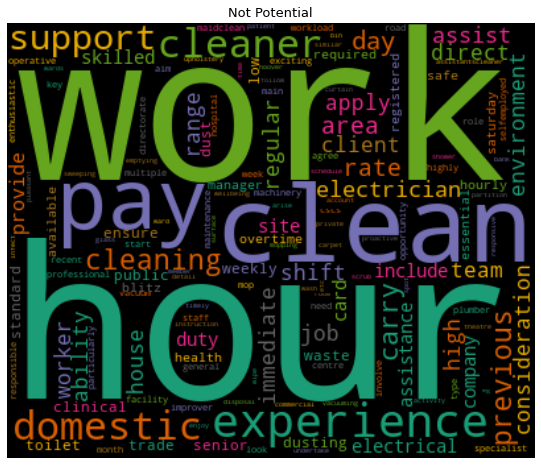

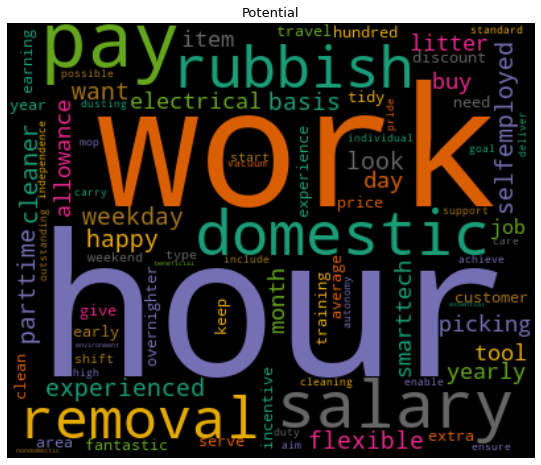

In [19]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap
from matplotlib import pyplot as plt

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
train_dtm=train_dtm.transpose()

# Plotting word cloud for each product
for index,summary in enumerate(train_dtm.columns):
  generate_wordcloud(train_dtm[summary].sort_values(ascending=False),summary)

In [20]:
from nltk import tokenize
#Transform text data to count matrix
word_vectorizer = TfidfVectorizer(sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    max_df=0.5,
    max_features=30000) 

word_features = word_vectorizer.fit_transform(train['tokenized_summary'].str.join(' '))

word_features

word_features.A

word_vectorizer.get_feature_names()

token = pd.DataFrame.sparse.from_spmatrix(word_features, columns=word_vectorizer.get_feature_names(),index=train.index)

print(token)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


      ability  able  access  accordance  ...  worker  workload      year  yearly
2285      0.0   0.0     0.0         0.0  ...     0.0       0.0  0.000000     0.0
1254      0.0   0.0     0.0         0.0  ...     0.0       0.0  0.000000     0.0
1022      0.0   0.0     0.0         0.0  ...     0.0       0.0  0.000000     0.0
2122      0.0   0.0     0.0         0.0  ...     0.0       0.0  0.303138     0.0
853       0.0   0.0     0.0         0.0  ...     0.0       0.0  0.000000     0.0
...       ...   ...     ...         ...  ...     ...       ...       ...     ...
1415      0.0   0.0     0.0         0.0  ...     0.0       0.0  0.000000     0.0
2579      0.0   0.0     0.0         0.0  ...     0.0       0.0  0.000000     0.0
69        0.0   0.0     0.0         0.0  ...     0.0       0.0  0.000000     0.0
1717      0.0   0.0     0.0         0.0  ...     0.0       0.0  0.000000     0.0
1195      0.0   0.0     0.0         0.0  ...     0.0       0.0  0.000000     0.0

[2317 rows x 352 columns]


##5. Data Pre-Processing

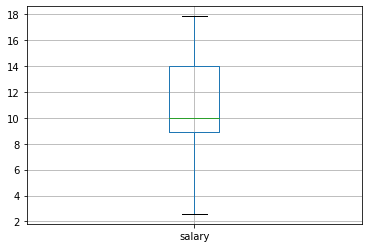

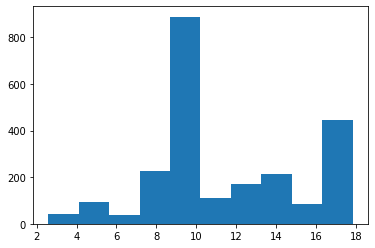

In [21]:
#Explore salary
train.boxplot(column=['salary'])
plt.show()

plt.hist(train.salary)
plt.show()


In [22]:
#Rename
train.rename(columns={'target ': 'target'}, inplace=True)
train.rename(columns={'salary': 'Salary'}, inplace=True)

In [23]:
train['target'].value_counts()

Not Potential    1270
Potential        1047
Name: target, dtype: int64

In [24]:
print(train.columns.tolist())

['Salary', 'summary', 'target', 'clean_summary', 'lemmatized_stopword_summary', 'tokenized_summary']


In [25]:
#Label encoding the target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train['target'] = label_encoder.fit_transform(train['target'])

display(train.head())

,Salary,summary,target,clean_summary,lemmatized_stopword_summary,tokenized_summary
2285,13.570000,Serving customers and keeping areas clean and ...,1,serving customers and keeping areas clean and ...,serve customer keep area clean tidy \n fantast...,"[serve, customer, keep, area, clean, tidy, fan..."
1254,5.947917,Our aim is to deliver outstanding care and sup...,1,our aim is to deliver outstanding care and sup...,aim deliver outstanding care support enable in...,"[aim, deliver, outstanding, care, support, ena..."
1022,8.910000,Your main aim will be to carry out a range of ...,0,your main aim will be to carry out a range of ...,main aim carry range clean activity health cen...,"[main, aim, carry, range, clean, activity, hea..."
2122,12.019231,Some travel and overnighters will be part of t...,1,some travel and overnighters will be part of t...,travel overnighter job \n day price work av...,"[travel, overnighter, job, day, price, work, a..."
853,13.570000,Serving customers and keeping areas clean and ...,1,serving customers and keeping areas clean and ...,serve customer keep area clean tidy \n fantast...,"[serve, customer, keep, area, clean, tidy, fan..."


In [26]:
train2 = pd.concat([train,token], axis=1)

In [27]:
display(train2)

,Salary,summary,target,clean_summary,lemmatized_stopword_summary,tokenized_summary,ability,able,access,accordance,account,achieve,activity,agree,aim,allowance,alongside,animal,annual,apartment,app,applicant,application,apply,appoint,area,arise,assist,assistance,assistant,assistantscleaner,association,autonomy,available,average,bank,base,basis,bed,belong,...,town,trade,training,travel,trust,type,typical,uk,understand,undertake,upholstery,use,usually,vacuum,vacuuming,varied,vision,visit,vital,wait,want,ward,wards,wash,waste,water,week,weekday,weekend,weekly,weeton,welfare,well,wellbeing,wipe,work,worker,workload,year,yearly
2285,13.570000,Serving customers and keeping areas clean and ...,1,serving customers and keeping areas clean and ...,serve customer keep area clean tidy \n fantast...,"[serve, customer, keep, area, clean, tidy, fan...",0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227159,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.26762,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
1254,5.947917,Our aim is to deliver outstanding care and sup...,1,our aim is to deliver outstanding care and sup...,aim deliver outstanding care support enable in...,"[aim, deliver, outstanding, care, support, ena...",0.0,0.0,0.0,0.0,0.0,0.300185,0.000000,0.0,0.255873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.300185,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
1022,8.910000,Your main aim will be to carry out a range of ...,0,your main aim will be to carry out a range of ...,main aim carry range clean activity health cen...,"[main, aim, carry, range, clean, activity, hea...",0.0,0.0,0.0,0.0,0.0,0.000000,0.284272,0.0,0.244580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246566,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
2122,12.019231,Some travel and overnighters will be part of t...,1,some travel and overnighters will be part of t...,travel overnighter job \n day price work av...,"[travel, overnighter, job, day, price, work, a...",0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.304329,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.00000,0.304329,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.149155,0.0,0.0,0.303138,0.0
853,13.570000,Serving customers and keeping areas clean and ...,1,serving customers and keeping areas clean and ...,serve customer keep area clean tidy \n fantast...,"[serve, customer, keep, area, clean, tidy, fan...",0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227159,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.26762,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [28]:
#Drop unnecessary columns
train3 = train2.drop(['summary','clean_summary','lemmatized_stopword_summary','tokenized_summary'], axis=1) 
display(train3)


,Salary,target,ability,able,access,accordance,account,achieve,activity,agree,aim,allowance,alongside,animal,annual,apartment,app,applicant,application,apply,appoint,area,arise,assist,assistance,assistant,assistantscleaner,association,autonomy,available,average,bank,base,basis,bed,belong,beneficial,big,bin,blitz,...,town,trade,training,travel,trust,type,typical,uk,understand,undertake,upholstery,use,usually,vacuum,vacuuming,varied,vision,visit,vital,wait,want,ward,wards,wash,waste,water,week,weekday,weekend,weekly,weeton,welfare,well,wellbeing,wipe,work,worker,workload,year,yearly
2285,13.570000,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227159,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.26762,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
1254,5.947917,1,0.0,0.0,0.0,0.0,0.0,0.300185,0.000000,0.0,0.255873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.300185,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
1022,8.910000,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.284272,0.0,0.244580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.285588,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246566,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
2122,12.019231,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.304329,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.304329,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.149155,0.0,0.0,0.303138,0.0
853,13.570000,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227159,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.26762,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,4.806490,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.389075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.438835,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
2579,17.109375,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.299954,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.299655,0.0,0.00000,0.0,0.0,0.0,0.0,0.299954,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.196017,0.0,0.0,0.000000,0.0
69,8.887420,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0

In [29]:
#Separate into predictor and target variable
X1 = train3['Salary']
X2 = train3.iloc[:,3:]
X = pd.concat([X1,X2], axis=1)
y = train3['target']

In [30]:
display(X)

,Salary,able,access,accordance,account,achieve,activity,agree,aim,allowance,alongside,animal,annual,apartment,app,applicant,application,apply,appoint,area,arise,assist,assistance,assistant,assistantscleaner,association,autonomy,available,average,bank,base,basis,bed,belong,beneficial,big,bin,blitz,building,business,...,town,trade,training,travel,trust,type,typical,uk,understand,undertake,upholstery,use,usually,vacuum,vacuuming,varied,vision,visit,vital,wait,want,ward,wards,wash,waste,water,week,weekday,weekend,weekly,weeton,welfare,well,wellbeing,wipe,work,worker,workload,year,yearly
2285,13.570000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227159,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.26762,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
1254,5.947917,0.0,0.0,0.0,0.0,0.300185,0.000000,0.0,0.255873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.300185,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
1022,8.910000,0.0,0.0,0.0,0.0,0.000000,0.284272,0.0,0.244580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.285588,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246566,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
2122,12.019231,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.304329,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.304329,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.149155,0.0,0.0,0.303138,0.0
853,13.570000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227159,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.26762,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,4.806490,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.389075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.438835,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
2579,17.109375,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.299954,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.299655,0.0,0.00000,0.0,0.0,0.0,0.0,0.299954,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.196017,0.0,0.0,0.000000,0.0
69,8.887420,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.

In [31]:
display(y)

2285    1
1254    1
1022    0
2122    1
853     1
       ..
1415    1
2579    1
69      0
1717    0
1195    1
Name: target, Length: 2317, dtype: int64

In [32]:
#Data Splitting

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3, random_state=13)

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1621, 352)
(1621,)
(696, 352)
(696,)


##8. Models Building

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


0.9771623831285899


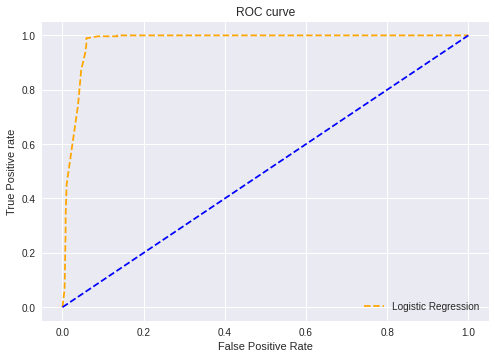

In [34]:
#1. Logistic Regression

model_LR = LogisticRegression()

#Fit model
model_LR.fit(X_train,y_train)

pred_prob1 = model_LR.predict_proba(X_test) 

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])

print(auc_score1)


# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


0.8275837491090521


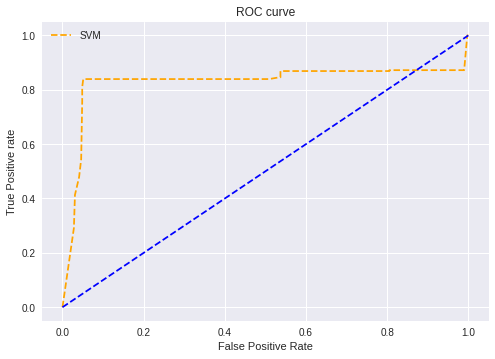

In [35]:
#2. SVM

model_SVM = svm.SVC(kernel='rbf', C=1e9, gamma=1e-07, probability=True) 

#Fit model
model_SVM.fit(X_train,y_train)

pred_prob2 = model_SVM.predict_proba(X_test) 

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# roc curve for models
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print(auc_score2)


# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr2, tpr2, linestyle='--',color='orange', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


0.9763825416125109


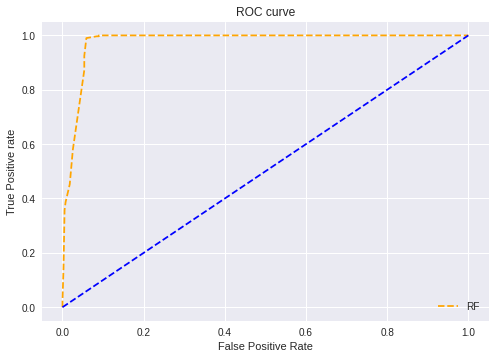

In [36]:
#3. Random Forest

model_RF = RandomForestClassifier(n_estimators=100, random_state=0)  

#Fit model
model_RF.fit(X_train,y_train)

pred_prob3 = model_RF.predict_proba(X_test) 

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# roc curve for models
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print(auc_score3)


# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr3, tpr3, linestyle='--',color='orange', label='RF')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


0.9781015471049432


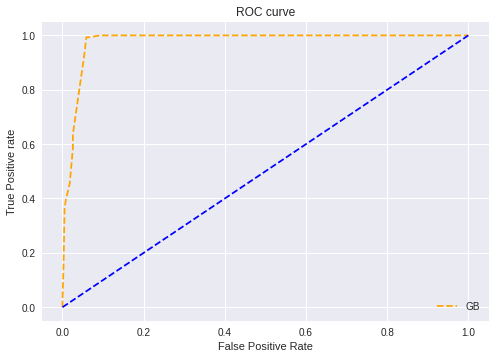

In [37]:
#4. Gradient Boosting

model_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

#Fit model
model_GB.fit(X_train,y_train)

pred_prob4 = model_GB.predict_proba(X_test) 

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# roc curve for models
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score4 = roc_auc_score(y_test, pred_prob4[:,1])

print(auc_score4)


# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr4, tpr4, linestyle='--',color='orange', label='GB')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();